## Predicting Istanbul public transport passengers

### Goals
To predict passenger counts for the future.

### Fetch the data

Let's start with getting the data.
We'll get our data from https://data.ibb.gov.tr/dataset/hourly-public-transport-data-set, which is a public data set that contains the following information:
- **transition_date**: It is the field that contains the transition date information. The data format is YYYY-MM-DD.
- **transition_hour**: It is the field that contains the transit time information. The data format is HH.
- **transport_type_id**: It contains the line information on which the transportation is provided, 1: OTOYOL (road), 2: RAYLI (railroad), 3: DENİZ (by sea).
- **road_type**: Label of transport_type_id.
- **transfer_type**: It is the field that shows the type of transit passengers using Public Transportation. Transfer: Travel by one or more public transport, Normal: Journey without transfer.
- **number_of_passage**: Includes the number of trips per hour, transfer type and transportation type.
- **number_of_passenger**: It includes the number of individual passengers traveling in the given hour, depending on the type of transfer and the type of transportation.

After February 2024, following columns were added:
- **product_kind**: Type of Istanbulkart used for payment, can be full, discounted, free etc.
- **transaction_type_desc**: Label of product_kind.
- **town**: District.
- **line_name**: Name of the public transportation line.

In [2]:
import download_data

url = "https://data.ibb.gov.tr/dataset/hourly-public-transport-data-set"

# Call the main function to download CSV files
total_files, downloaded_files, skipped_files = download_data.fetch(url)

print(f"Total files available: {total_files}")
print(f"Files downloaded: {downloaded_files}")
print(f"Files skipped: {skipped_files}")

Total files available: 54
Files downloaded: 0
Files skipped: 54


### Parse the data

Import all CSVs into a `pandas.DataFrame` for inspection.

In [3]:
import pandas as pd
import os

path = 'data'
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]

data_frames = [pd.read_csv(os.path.join(path, file)) for file in csv_files]
df = pd.concat(data_frames, ignore_index=True)
df.shape

(66299594, 12)

Let's check for `isna()` to see if there are columns we cannot use.

In [4]:
df.isna().sum()

transition_date                 0
transition_hour                 0
transport_type_id               0
road_type                       0
line                            0
transfer_type                   0
number_of_passage               0
number_of_passenger             0
product_kind             54398908
transaction_type_desc    54145758
town                     54202254
line_name                54158671
dtype: int64

New columns (`product_kind`, `transaction_type_desc`, `town`, `line_name`) seems to be missing for most of the rows, it should just be better to exclude them altogether.

In [5]:
df.drop(["product_kind", "transaction_type_desc", "town", "line_name"], axis=1, inplace=True)
df.shape

(66299594, 8)

In [6]:
df['transition_datetime'] = pd.to_datetime(df['transition_date'] + ' ' + df['transition_hour'].astype(str) + ':00')
df.drop(columns=['transition_date', 'transition_hour'], inplace=True)

# Let's keep the same order
column_order = ['transition_datetime', 'transport_type_id', 'road_type', 'line', 'transfer_type', 'number_of_passage', 'number_of_passenger']
df = df[column_order]

Let's group by the rows to avoid spreading the data like:
>66299591	1	OTOYOL	SULTANBEYLI-UMRANIYE	Normal	4	3	2024-06-30 09:00:00
>
>66299592	1	OTOYOL	SULTANBEYLI-UMRANIYE	Normal	1	1	2024-06-30 09:00:00
>
>66299593	1	OTOYOL	SULTANBEYLI-UMRANIYE	Normal	1	1	2024-06-30 09:00:00

In [7]:
df = df.groupby(['transition_datetime', 'transport_type_id', 'road_type', 'line', 'transfer_type']).agg({
    'number_of_passage': 'sum',
    'number_of_passenger': 'sum'
}).reset_index()

Let's also drop `road_type` as it doesn't add any value to the data.

In [8]:
df.drop("road_type", axis=1, inplace=True)
df

,transition_datetime,transport_type_id,line,transfer_type,number_of_passage,number_of_passenger
0,2020-01-01 00:00:00,1,A.YESEVI MAH-UMRANIYE,Aktarma,3,3
1,2020-01-01 00:00:00,1,A.YESEVI MAH-UMRANIYE,Normal,19,19
2,2020-01-01 00:00:00,1,ADEM YAVUZ MAH-ZIVERBEY-KADIKOY,Aktarma,5,5
3,2020-01-01 00:00:00,1,ADEM YAVUZ MAH-ZIVERBEY-KADIKOY,Normal,97,88
4,2020-01-01 00:00:00,1,ALEMDAR-HALICIOGLU,Aktarma,6,6
...,...,...,...,...,...,...
32037073,2024-06-30 06:00:00,1,SULTANBEYLI-UMRANIYE,Normal,55,52
32037074,2024-06-30 07:00:00,1,SULTANBEYLI-UMRANIYE,Aktarma,1,1
32037075,2024-06-30 07:00:00,1,SULTANBEYLI-UMRANIYE,Normal,35,34
32037076,2024-06-30 08:00:00,1,SULTANBEYLI-UMRANIYE,Normal,76,74


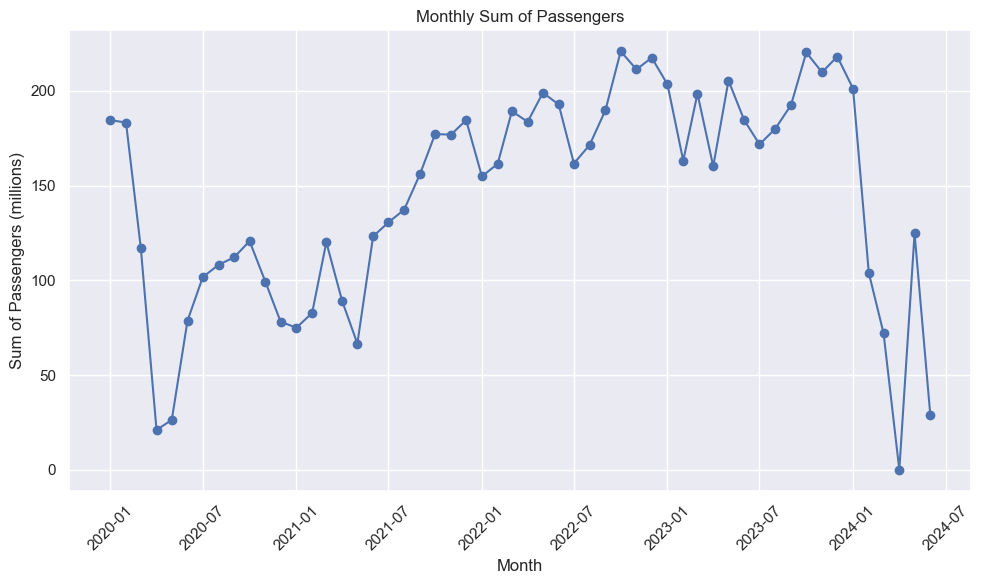

In [18]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

# Convert 'transition_datetime' to datetime
df['transition_datetime'] = pd.to_datetime(df['transition_datetime'])

# Extract the year and month from the datetime
df['year_month'] = df['transition_datetime'].dt.to_period('M')

# Group by the year_month and calculate the average number of passengers
monthly_avg = df.groupby('year_month')['number_of_passenger'].sum().reset_index()

# Convert year_month back to datetime for plotting
monthly_avg['year_month'] = monthly_avg['year_month'].dt.to_timestamp()

# Normalize the y-axis values to thousands (K)
monthly_avg['number_of_passenger'] = monthly_avg['number_of_passenger'] / 1_000_000

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(monthly_avg['year_month'], monthly_avg['number_of_passenger'], marker='o')

# Format the plot
plt.xlabel('Month')
plt.ylabel('Sum of Passengers (millions)')
plt.title('Monthly Sum of Passengers')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show();